# DEA Coastlines raster generation <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This code conducts raster generation for DEA Coastlines:

* Load stack of all available Landsat 5, 7 and 8 satellite imagery for a location using [ODC Virtual Products](https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Virtual_products.html)
* Convert each satellite image into a remote sensing water index (MNDWI)
* For each satellite image, model ocean tides into a 2 x 2 km grid based on exact time of image acquisition
* Interpolate tide heights into spatial extent of image stack
* Mask out high and low tide pixels by removing all observations acquired outside of 50 percent of the observed tidal range centered over mean sea level
* Combine tidally-masked data into annual median composites from 1988 to the present representing the coastline at approximately mean sea level

This is an interactive version of the code intended for prototyping; to run this analysis at scale, run `dea_coastlines.raster.py`.

---

In [ ]:
pip install mock

In [ ]:
pip install topojson

## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [2]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import datacube
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from functools import partial
from datacube.utils.geometry import Geometry
from dea_tools.dask import create_local_dask_cluster

# Load raster generation DEA Coastlines code
sys.path.insert(0, '..')
import dea_coastlines.raster

# Connect to datacube
dc = datacube.Datacube(app='DEACoastlines')

# Create local dask client for parallelisation
client = create_local_dask_cluster(return_client=True)


Client Scheduler: tcp://127.0.0.1:37009 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 125.85 GB


## Setup
### Set analysis parameters

In [2]:
study_area = 8434  # 8335
raster_version = 'refactor_test'

### Load supplementary data

In [3]:
# Tide points are used to model tides across the extent of the satellite data
points_gdf = gpd.read_file('../data/raw/tide_points_coastal.geojson')

# Albers grid cells used to process the analysis
gridcell_gdf = (gpd.read_file('../data/raw/50km_albers_grid_clipped.geojson')
                .to_crs(epsg=4326)
                .set_index('id'))
gridcell_gdf.index = gridcell_gdf.index.astype(str)
gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

## Loading data
### Create spatiotemporal query
This establishes the spatial and temporal extent used to search for Landsat satellite data.


In [4]:
# Create query based on analysis gridcell extent
geopoly = Geometry(gridcell_gdf.iloc[0].geometry, crs=gridcell_gdf.crs)
query = {'geopolygon': geopoly.buffer(0.05),
         'time': ('1987', '2021'),  # 1987, 2021
         'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}}


### Load satellite data as MNDWI
This step loads satellite data from Landsat 5, 7 and 8, and returns the data as a cloud-masked array converted to the Modified Normalised Difference Water Index (MNDWI).
For Digital Earth Australia Coastlines, this is achieved using [ODC Virtual Products](https://docs.dea.ga.gov.au/notebooks/Frequently_used_code/Virtual_products.html).

In [5]:
# Load MNDWI virtual product
ds = dea_coastlines.raster.load_mndwi(
    dc,
    query,
    yaml_path='../configs/deacoastlines_virtual_products_v1.0.0.yaml',
    product_name='ls_nbart_mndwi')
ds

<xarray.Dataset>
Dimensions:      (time: 1392, y: 1630, x: 1218)
Coordinates:
  * time         (time) datetime64[ns] 1987-05-22T23:06:55.973236 ... 2021-10...
  * y            (y) float64 -3.33e+06 -3.33e+06 ... -3.379e+06 -3.379e+06
  * x            (x) float64 5.043e+05 5.044e+05 ... 5.408e+05 5.408e+05
    spatial_ref  int32 32656
Data variables:
    mndwi        (time, y, x) float32 dask.array<chunksize=(1, 1630, 1218), meta=np.ndarray>
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

## Tidal modelling
### Model tides at point locations
Model tides at each point in a provided `geopandas.GeoDataFrame` based on all timesteps observed by Landsat. This returns a new `geopandas.GeoDataFrame` with a "time" index 
(matching every time step in our Landsat data), and a "tide_m" column giving the 
tide heights at each point location at that time.

<AxesSubplot:>

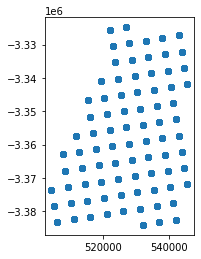

In [161]:
tidepoints_gdf = dea_coastlines.raster.model_tide_points(ds, points_gdf)
tidepoints_gdf.plot()

### Interpolate tides into each satellite timestep
For each satellite timestep, spatially interpolate our modelled tide height points into the spatial extent of our satellite image, and add this new data as a new variable in our satellite dataset. This allows each satellite pixel to be analysed and filtered/masked based on the tide height at the exact moment of satellite image acquisition. 

In [54]:
# Interpolate tides for each timestep in `ds`
ds['tide_m'] = dea_coastlines.raster.multiprocess_apply(
    ds=ds,
    dim='time',
    func=partial(dea_coastlines.raster.interpolate_tide,
                 tidepoints_gdf=tidepoints_gdf))

Parallelising 15 processes


<xarray.DataArray (time: 1391, y: 1630, x: 1218)>
array([[[-0.46036288, -0.46024618, -0.46012944, ..., -0.41344637,
         -0.41341123, -0.4133761 ],
        [-0.4602905 , -0.46017385, -0.46005723, ..., -0.41348276,
         -0.41344762, -0.4134125 ],
        [-0.46021807, -0.46010154, -0.459985  , ..., -0.41351914,
         -0.41348404, -0.41344893],
        ...,
        [-0.40034965, -0.40031156, -0.40027347, ..., -0.4010232 ,
         -0.4010241 , -0.40102497],
        [-0.40034646, -0.4003082 , -0.4002699 , ..., -0.4010012 ,
         -0.4010021 , -0.401003  ],
        [-0.40034327, -0.4003048 , -0.40026635, ..., -0.4009792 ,
         -0.4009801 , -0.400981  ]],

       [[ 0.48113132,  0.480995  ,  0.48085868, ...,  0.41691872,
          0.4168755 ,  0.41683227],
        [ 0.48106554,  0.48092932,  0.4807931 , ...,  0.4169645 ,
          0.41692135,  0.4168782 ],
        [ 0.48099974,  0.4808636 ,  0.48072746, ...,  0.41701028,
          0.41696718,  0.41692412],
...
        [ 0.40242228,  0.4023791 ,  0.40233588, ...,  0.39741826,
          0.39741609,  0.39741388],
        [ 0.4024131 ,  0.40236974,  0.40232635, ...,  0.3974034 ,
          0.39740127,  0.39739916],
        [ 0.40240392,  0.40236038,  0.40231684, ...,  0.3973885 ,
          0.39738646,  0.3973844 ]],

       [[ 0.32561105,  0.32551825,  0.32542545, ...,  0.27917546,
          0.27914998,  0.2791245 ],
        [ 0.32556635,  0.3254736 ,  0.32538086, ...,  0.27920684,
          0.27918136,  0.27915588],
        [ 0.32552162,  0.32542893,  0.32533625, ...,  0.27923825,
          0.27921274,  0.27918726],
        ...,
        [ 0.2967191 ,  0.29670027,  0.29668143, ...,  0.29643548,
          0.29643378,  0.29643205],
        [ 0.29671958,  0.29670063,  0.2966817 , ...,  0.29642144,
          0.2964197 ,  0.29641798],
        [ 0.2967201 ,  0.296701  ,  0.29668197, ...,  0.2964074 ,
          0.29640564,  0.29640388]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 1987-05-22T23:06:55.973236 ... 2021-10...
  * y            (y) float64 -3.33e+06 -3.33e+06 ... -3.379e+06 -3.379e+06
  * x            (x) float64 5.043e+05 5.044e+05 ... 5.408e+05 5.408e+05
    spatial_ref  int32 32656

Plot example interpolated tide surface for a single timestep:

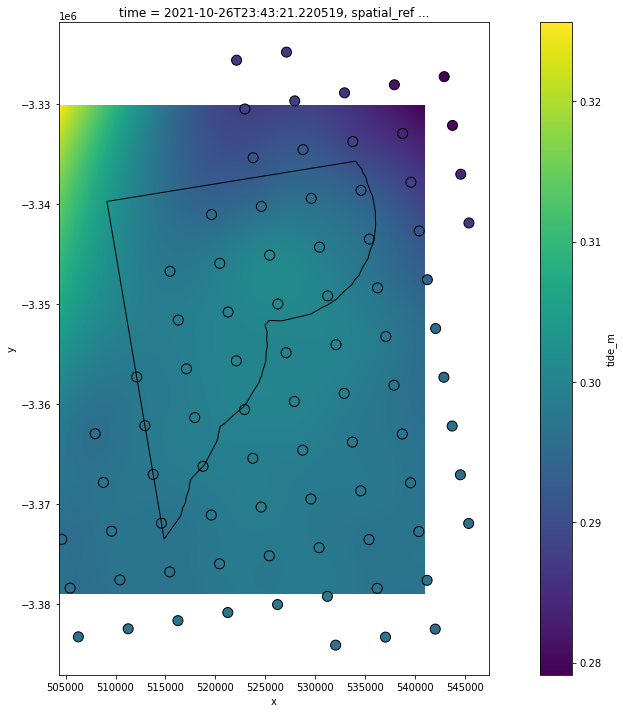

In [57]:
import matplotlib.pyplot as plt

# Plot 
ds_i = ds['tide_m'].isel(time=-1).compute()
ds_i.plot.imshow(robust=True, 
                 cmap='viridis', 
                 size=12, 
                 vmin=ds_i.min().item(), 
                 vmax=ds_i.max().item())
tidepoints_gdf.loc[str(ds_i.time.values)[0:10]].plot(ax=plt.gca(), 
                                                     column='tide_m', 
                                                     cmap='viridis', 
                                                     markersize=100,
                                                     edgecolor='black',
                                                     vmin=ds_i.min().item(),
                                                     vmax=ds_i.max().item())
gridcell_gdf.to_crs(tidepoints_gdf.crs).plot(ax=plt.gca(), 
                                             facecolor='none',
                                             edgecolor='black');

### Calculate per-pixel tide cutoffs
Based on the entire time-series of tide heights, compute the max and min satellite-observed tide height for each pixel, then calculate tide cutoffs used to restrict our data to satellite observations centred over mid-tide (0 m Above Mean Sea Level).

In [52]:
# Determine tide cutoff
tide_cutoff_buff = (
    (ds['tide_m'].max(dim='time') - ds['tide_m'].min(dim='time')) * 0.25)
tide_cutoff_min = 0.0 - tide_cutoff_buff
tide_cutoff_max = 0.0 + tide_cutoff_buff

## Generate yearly composites
Export tidally-masked MNDWI median composites for each year, and three-yearly composites used to gapfill poor data coverage areas.

In [53]:
# If output folder doesn't exist, create it
output_dir = f'../data/interim/raster/{raster_version}/{study_area}_{raster_version}'
os.makedirs(output_dir, exist_ok=True)

# Iterate through each year and export annual and 3-year gapfill composites
dea_coastlines.raster.export_annual_gapfill(ds, output_dir, tide_cutoff_min,
                                            tide_cutoff_max)

Processing 1987
Processing 1988
Processing 1989
Processing 1990
Processing 1991
Processing 1992
Processing 1993
Processing 1994
Processing 1995
Processing 1996
Processing 1997
Processing 1998
Processing 1999
Processing 2000
Processing 2001
Processing 2002
Processing 2003
Processing 2004
Processing 2005
Processing 2006
Processing 2007
Processing 2008
Processing 2009
Processing 2010
Processing 2011
Processing 2012
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019
Processing 2020
Processing 2021


### Close Dask client

In [37]:
client.close()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/DEACoastLines/issues/new). For questions or more information about this product, sign up to the [Open Data Cube Slack](https://join.slack.com/t/opendatacube/shared_invite/zt-d6hu7l35-CGDhSxiSmTwacKNuXWFUkg) and post on the [`#dea-coastlines`](https://app.slack.com/client/T0L4V0TFT/C018X6J9HLY/details/) channel.

**Last modified:** November 2021